In [60]:
import csv, sqlite3
import matplotlib 
matplotlib.use('nbagg')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine


In [61]:
connex = sqlite3.connect("trip.db")  # Opens file if exists, else creates file 

Write csv to database

In [3]:
for chunk in pd.read_csv("trip.csv", chunksize=2000):
    chunk.to_sql(name="trip", con=connex, if_exists="append", index=False)  #"name" is name of table 

### Trip pattern look up 

In [215]:
cur1 = connex.cursor() # This object lets us actually send messages to our DB and receive results
cur1.execute('SELECT start_year, start_month, COUNT(*) AS num_trip FROM trip GROUP BY start_year, start_month')
rows1 = cur1.fetchall()
df1 = pd.DataFrame([[int(ij) for ij in i] for i in rows1])
df1.columns = ['year', 'month', 'num_trips']
df1['date'] = df1['year'].map(str) + '/' + df1['month'].map(str)

In [64]:
cur2 = connex.cursor()
cur2.execute('SELECT start_year, start_month, COUNT(*) AS num_member FROM trip WHERE usertype == "Subscriber" GROUP BY start_year, start_month')
rows2 = cur2.fetchall()
df2 = pd.DataFrame([[int(ij) for ij in i] for i in rows2])
df2.columns = ['year', 'month', 'num_member']
df2['date'] = df2['year'].map(str) + '/' + df2['month'].map(str)

In [65]:
df1['num_member'] = df2['num_member']

<IPython.core.display.Javascript object>


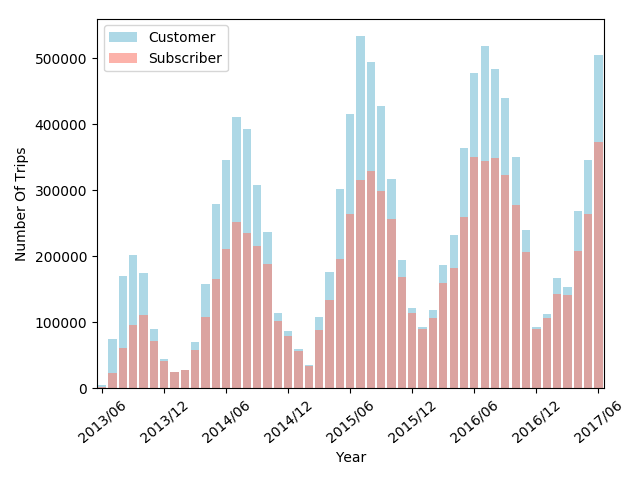

In [207]:
fig, ax1 = plt.subplots()
x_pos = np.arange(len(df1['date']))
ax1.bar(x_pos, df1['num_trips'], color = 'lightblue', align = 'center', label = 'Customer')
ax1.bar(x_pos, df1['num_member'], color = 'salmon', label = 'Subscriber', alpha = 0.6)
# ax2 = ax1.twinx()
# ax2.plot(df2['date'], df2['num_member'], color = 'red')
ax1.set(xlim=(-0.5, 48.5), xlabel = 'Year', ylabel = 'Number Of Trips')
# ax2.set(ylabel = 'Number Of Trip Made By Members')
ax1.xaxis.set(ticks=range(0, 52, 6), ticklabels=['2013/06','2013/12','2014/06','2014/12','2015/06','2015/12','2016/06','2016/12','2017/06']) 
plt.xticks(rotation=40)
plt.tight_layout()
plt.legend()
# ax.set_xticklabels(rotation = 40)
plt.show()

### Trip Distribution 

In [103]:
cur3 = connex.cursor()
cur3.execute('SELECT tripduration FROM trip')
rows3 = cur3.fetchall()
df3 = pd.DataFrame([[float(ij)/60 for ij in i] for i in rows3])
df3.columns = ['trip_duration']

<IPython.core.display.Javascript object>


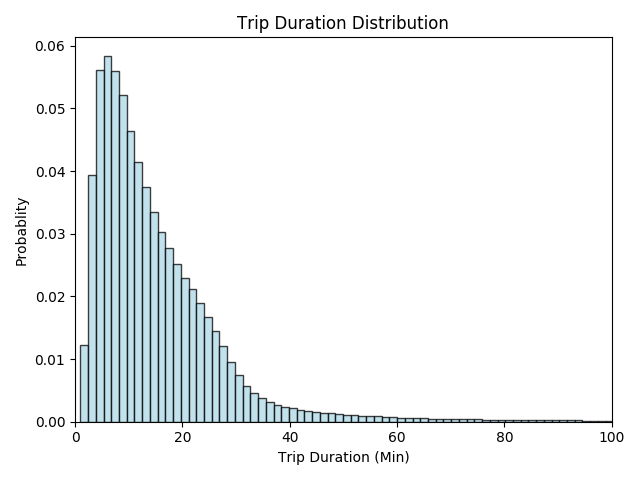

In [116]:
fig, ax = plt.subplots()
ax.hist(df3['trip_duration'], 1000, density = True, facecolor = 'lightblue', alpha = 0.75, ec = 'k')
ax.set(xlim=(0, 100), xlabel = 'Trip Duration (Min)', ylabel = 'Probablity', title = 'Trip Duration Distribution')
plt.tight_layout()
plt.show()

In [120]:
cur4 = connex.cursor()
cur4.execute('SELECT start_year, start_month, start_day, start_hour, COUNT(*) AS num_trip FROM trip GROUP BY start_year, start_month, start_day, start_hour')
rows4 = cur4.fetchall()
df4 = pd.DataFrame([[int(ij) for ij in i] for i in rows4])
df4.columns = ['year', 'month', 'day', 'hour', 'num_trip']

<IPython.core.display.Javascript object>


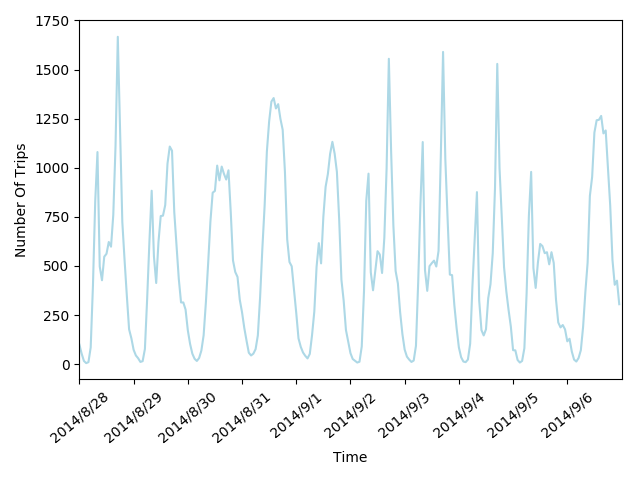

In [134]:
fig3, ax = plt.subplots()
x_range = list(range(240))
ax.plot(x_range, df4['num_trip'][10014:10254], color = 'lightblue', label = 'Total')
# ax1.bar(x_pos, df1['num_member'], color = 'salmon', label = 'Subscriber', alpha = 0.6)
# ax2 = ax1.twinx()
# ax2.plot(df2['date'], df2['num_member'], color = 'red')
ax.set(xlim=(0, 240), xlabel = 'Time', ylabel = 'Number Of Trips')
# ax2.set(ylabel = 'Number Of Trip Made By Members')
ax.xaxis.set(ticks=range(0, 240, 24), ticklabels=['2014/8/28','2014/8/29','2014/8/30','2014/8/31','2014/9/1','2014/9/2','2014/9/3','2014/9/4','2014/9/5','2014/9/6']) 
plt.xticks(rotation=40)
plt.tight_layout()
# plt.legend()
# ax.set_xticklabels(rotation = 40)
plt.show()

In [157]:
df4.head()

,year,month,day,hour,num_trip
0,2013,6,27,1,1
1,2013,6,27,11,4
2,2013,6,27,12,3
3,2013,6,27,13,2
4,2013,6,27,14,5


### Trip demand prediction 

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [209]:
def prepare_data(data, lags=1):
    """
    Create lagged data from an input time series
    """
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X), np.array(y)

In [216]:
np.random.seed(1)
data = df4['num_trip'].values
data = data.astype('float32')
data = data.reshape(len(data),1)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)
l, w = dataset.shape
# split into train and test sets
train = dataset[0:27873, :]
test = dataset[27873:, :]
# reshape into X=t and Y=t+1
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [217]:
# create and fit the LSTM network
mdl = Sequential()
mdl.add(Dense(3, input_shape=(1, lags), activation='relu'))
mdl.add(LSTM(6, activation='relu'))
mdl.add(Dense(1, activation='relu'))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=60, batch_size=32, verbose=2)

Epoch 1/60
 - 11s - loss: 0.0086
Epoch 2/60
 - 9s - loss: 0.0035
Epoch 3/60
 - 9s - loss: 0.0032
Epoch 4/60
 - 9s - loss: 0.0031
Epoch 5/60
 - 9s - loss: 0.0031
Epoch 6/60
 - 9s - loss: 0.0030
Epoch 7/60
 - 9s - loss: 0.0030
Epoch 8/60
 - 9s - loss: 0.0029
Epoch 9/60
 - 9s - loss: 0.0029
Epoch 10/60
 - 9s - loss: 0.0029
Epoch 11/60
 - 9s - loss: 0.0029
Epoch 12/60
 - 9s - loss: 0.0029
Epoch 13/60
 - 9s - loss: 0.0029
Epoch 14/60
 - 8s - loss: 0.0028
Epoch 15/60
 - 9s - loss: 0.0028
Epoch 16/60
 - 8s - loss: 0.0028
Epoch 17/60
 - 9s - loss: 0.0028
Epoch 18/60
 - 9s - loss: 0.0028
Epoch 19/60
 - 9s - loss: 0.0028
Epoch 20/60
 - 9s - loss: 0.0028
Epoch 21/60
 - 9s - loss: 0.0027
Epoch 22/60
 - 9s - loss: 0.0027
Epoch 23/60
 - 9s - loss: 0.0027
Epoch 24/60
 - 9s - loss: 0.0027
Epoch 25/60
 - 9s - loss: 0.0026
Epoch 26/60
 - 9s - loss: 0.0026
Epoch 27/60
 - 9s - loss: 0.0025
Epoch 28/60
 - 9s - loss: 0.0024
Epoch 29/60
 - 9s - loss: 0.0023
Epoch 30/60
 - 9s - loss: 0.0022
Epoch 31/60
 - 8s 

In [218]:
# make predictions
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)
 
# invert transformation
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
 
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('Train Score: {:.2f} RMSE'.format(train_score))
test_score = math.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test Score: {:.2f} RMSE'.format(test_score))

Train Score: 110.55 RMSE
Test Score: 118.55 RMSE


In [219]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags:len(train_predict)+lags, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (lags * 2)+1:len(data)-1, :] = test_predict
 


<IPython.core.display.Javascript object>


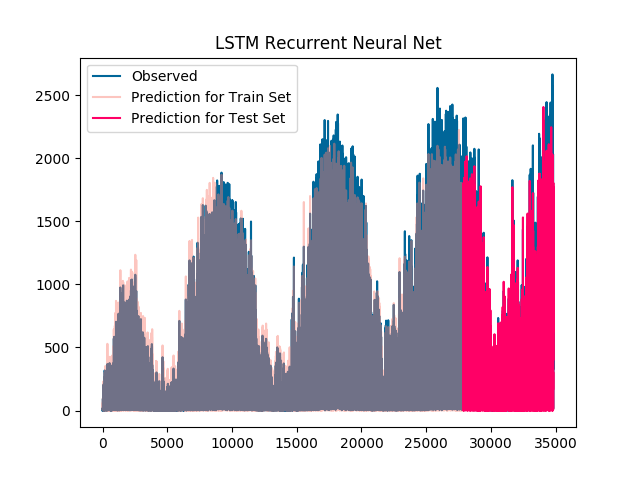

In [220]:
# plot observation and predictions
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='salmon', alpha=0.45);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='upper left')
plt.title('LSTM Recurrent Neural Net')
plt.show()

<IPython.core.display.Javascript object>


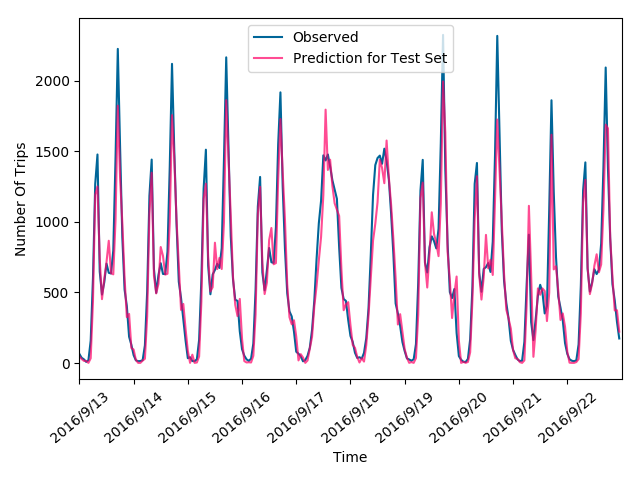

In [201]:
fig5, ax5 = plt.subplots()
x_range = list(range(240))
ax5.plot(x_range, data[27876:28116], color = '#006699', label = 'Observed')
ax5.plot(x_range, test_predict_plot[27876:28116], label='Prediction for Test Set', color='#ff0066', alpha=0.7)
ax5.set(xlim=(0, 240), xlabel = 'Time', ylabel = 'Number Of Trips')
ax5.xaxis.set(ticks=range(0, 240, 24), ticklabels=['2016/9/13','2016/9/14','2016/9/15','2016/9/16','2016/9/17','2016/9/18','2016/9/19','2016/9/20','2016/9/21','2016/9/22']) 
plt.xticks(rotation=40)
plt.tight_layout()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


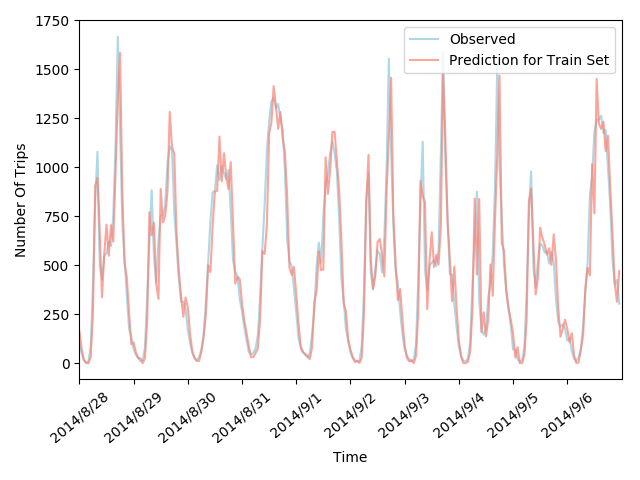

In [221]:
fig6, ax6 = plt.subplots()
x_range = list(range(240))
ax6.plot(x_range, data[10014:10254], color = 'lightblue', label = 'Observed')
ax6.plot(x_range, train_predict_plot[10014:10254], label='Prediction for Train Set', color='salmon', alpha=0.7)
ax6.set(xlim=(0, 240), xlabel = 'Time', ylabel = 'Number Of Trips')
ax6.xaxis.set(ticks=range(0, 240, 24), ticklabels=['2014/8/28','2014/8/29','2014/8/30','2014/8/31','2014/9/1','2014/9/2','2014/9/3','2014/9/4','2014/9/5','2014/9/6']) 
plt.xticks(rotation=40)
plt.tight_layout()
plt.legend()
plt.show()